## 2. Feature Extraction for Anomaly Detection
#### Alex Gagliano (gaglian2@mit.edu), IAIFI - January 8th, 2024

To facilitate the discovery of `out-of-distribution' data instances, it's often useful to work with fewer dimensions than the full data space. This brings us to the world of feature extraction. Be careful - we impose certain inductive biases in crafting these features that influence the types of anomalies to which we are sensitive! In the simplest case, we can manually construct these features based on what we think will be important.

## 2.1: Extracting Physical Features (Brightness and Timescale)

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from IPython.display import Image
from astropy.timeseries import LombScargleMultiband
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.over_sampling import SMOTE
from collections import Counter 
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import hdbscan

In [30]:
# A very simple case - calculating the peak absolute brightness and the number of days above the mean brightness
# The advantage is that this is model-independent and fast to calculate
lcs = pd.read_csv("../data/plasticc_train_lightcurves.csv")
lcs_detected = lcs[lcs['detected_bool'] == True]
dftrain_metadata = pd.read_csv("../data/plasticc_train_metadata.csv")
lcs_wMetadata = lcs.merge(dftrain_metadata)

# Convert flux to apparent brightness as in the previous tutorial
zpt = 27.5
lcs_wMetadata['apparent_mag'] = zpt - 2.5*np.log10(lcs_wMetadata['flux'].values)
lcs_wMetadata['mag_err'] = 1.0857 * np.abs(lcs_wMetadata['flux_err'].values/lcs_wMetadata['flux'].values)

/var/folders/y1/n43fk0m97tg8sbqh5j222kqw0000gn/T/ipykernel_94042/701248626.py:10: RuntimeWarning: invalid value encountered in log10
  lcs_wMetadata['apparent_mag'] = zpt - 2.5*np.log10(lcs_wMetadata['flux'].values)


In [31]:
# First, we loop through all transients in the training set and compute 
# -peak apparent brightness in each band, and 
# -Timescale (in days) as estimated by a Lomb-Scargle Periodogram. For more information
#  on the Lomb-Scargle, check out VanderPlas et al., 2018.
oids = np.unique(lcs_wMetadata['object_id'])
peakMags_set = []
period_set = []
true_target = []
hostgal_photoz = []
hostgal_photoz_err = []
#loop through transient object_ids 
for oid in oids:
    lc = lcs_wMetadata[lcs_wMetadata['object_id'] == oid]
    peakMags = []
    periods = []
    for i in np.arange(6):
        lc_passband = lc[lc['passband'] == i]

        #this can fail if there are no observations in a given band
        try:
            peakMags.append(np.nanmin(lc_passband['apparent_mag'])) 
        except ValueError:
            peakMags.append(np.nan)

    # t_min and t_max set the bounds of our period search. If 
    # you have more information about the transients in the training set,
    # you can impose stricter bounds!
    t_min = max(np.median(np.diff(sorted(lc['flux']))), 0.1)
    t_max = min(10., (lc['mjd'].max() - lc['mjd'].min())/2.)
    # the periodogram search happens in frequency (not period) space
    freq = np.linspace(1/t_max, 1/t_min, 500)
    try:
        # we use the 'fast' method to get through all events, though it is less accurate
        power = LombScargleMultiband(lc['mjd'], lc['flux'], lc['passband'], lc['flux_err']).power(freq, method='fast')
        best_period = 1/freq[np.argmax(power)]
        periods.append(best_period)
    except ValueError:
        periods.append(np.nan)
        
    # tack on some additional metadata about the transients that will become useful, including the true class and the photometric redshift.
    true_target.append(lc['true_target'].values[0])
    hostgal_photoz.append(lc['hostgal_photoz'].values[0])
    hostgal_photoz_err.append(lc['hostgal_photoz_err'].values[0])
    peakMags_set.append(peakMags)
    period_set.append(periods)

/var/folders/y1/n43fk0m97tg8sbqh5j222kqw0000gn/T/ipykernel_94042/915775647.py:21: RuntimeWarning: All-NaN axis encountered
  peakMags.append(np.nanmin(lc_passband['apparent_mag']))


In [32]:
# Create the pandas dataframe of curated features
labels = np.concatenate([[x+'PeakMag' for x in 'ugrizY'], ['Period(Days)']])
featureTable = pd.DataFrame(data=np.hstack([np.array(peakMags_set), np.array(period_set)]), columns=labels)

# Stack on some relevant metadata
featureTable['true_target'] = true_target
featureTable['hostgal_photoz'] = hostgal_photoz
featureTable['hostgal_photoz_err'] = hostgal_photoz_err

We can see that there were some failed calculations, so we'll have to impute the data before exploring it!

In [33]:
# This is an iterative technique where we loop through every feature, fit a regressor, and use it to predict the missing values.
imp = IterativeImputer(max_iter=10, random_state=0)
featureTable_imputed = pd.DataFrame(data=imp.fit_transform(featureTable), columns=featureTable.columns.values)

/Users/alexgagliano/miniconda3/lib/python3.11/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Surely an important piece to consider is how imbalanced the data is. We can use something like the SMOTE package to re-balance them: 

In [34]:
# SMOTE works by interpolating between instances of minority classes. 
# There's extensive literature on oversampling techniques - some light background reading on SMOTE can be found at 
# https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/.
X = featureTable_imputed.drop(columns=['true_target'])
y = featureTable_imputed['true_target']

oversample = SMOTE()
X_res, y_res = oversample.fit_resample(X, y)

Now we can start doing some exploration. 

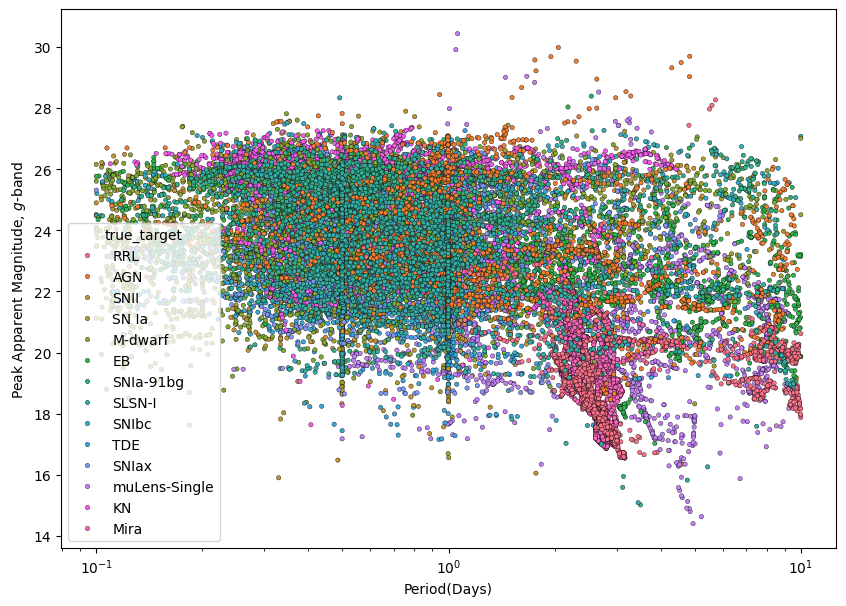

In [35]:
model_nums = {90:'SN Ia', 67:'SNIa-91bg', 52:'SNIax', 42:'SNII', 62:'SNIbc', 95:'SLSN-I', 15:'TDE', 64:'KN', 88:'AGN', 92:'RRL', 65:'M-dwarf', 16:'EB', 53:'Mira', 6:'muLens-Single', 991:'muLens-Binary', 992:'ILOT', 993:'CaRT', 994:'PISN', 995:'muLens-String'}
y_res_names = y_res.map(model_nums)

plt.figure(figsize=(10,7))
sns.scatterplot(x=X_res['Period(Days)'], y=X_res['gPeakMag'], hue=y_res_names, ec='k', s=10, legend=True);
plt.xscale("log")
plt.ylabel(r"Peak Apparent Magnitude, $g$-band");
plt.xlabel("Period(Days)");

Some interesting structure here - it looks like Mira variables and RR-lyrae lay off bottom-right, distinct from the rest of the distribution in how bright they are (in apparent brightness, not intrinsic brightness). It also looks like microlensing events and AGN fall all over the place - likely the periodogram struggled for those complex light curves. Let's pass it through a very simple anomaly detection algorithm, the isolation forest. This method (and many others for anomaly detection) are distance-based: the depth of the decision tree required to separate a sample is a consequence of its distance to other points in the data space.

In [36]:
# a helper function to get the composition of identified outliers (and inliers)
def getOutliers(y_list, outlier_scores, asc=False):
    # get the names of the transients
    y_names = np.vectorize(model_nums.get)(y_list)
        
    idx_sorted = np.argsort(outlier_scores)

    #do larger numbers correspond to a higher anomaly score?
    #if so, flip
    if asc: 
        idx_sorted = idx_sorted[::-1]
        
    #get the top 100 outliers and the top 100 inliers
    outliers = y_names[idx_sorted][0:100]
    inliers = y_names[idx_sorted][-100:]
    
    c =  Counter(outliers)
    c_ranked = [(i, c[i] / len(outliers) * 100.0) for i, count in c.most_common()]
    print("Composition of labeled outliers:",c_ranked)
    
    c =  Counter(inliers)
    c_ranked = [(i, c[i] / len(inliers) * 100.0) for i, count in c.most_common()]
    print("Composition of labeled inliers:", c_ranked)

In [37]:
clf = IsolationForest(max_samples=100, random_state=0)

# Outliers are given the label -1, and inliers are given the label 1
outlier_scores = clf.fit_predict(X_res)
getOutliers(y_res, outlier_scores)

Composition of labeled outliers: [('muLens-Single', 80.0), ('SNIa-91bg', 19.0), ('SLSN-I', 1.0)]
Composition of labeled inliers: [('EB', 51.0), ('TDE', 48.0), ('SNIax', 1.0)]


Indeed we see that Miras are predicted as anomalous most often in the training set. 
Let's now use the local outlier factor, another simple method. This one uses the local density of points to find anomalies, defined by their low density relative to their neighbors. Note that oversampling might not be the best idea here, as no points would be low-density!

In [38]:
# contamination defines the fraction of anomalies we believe to be in the dataset
clf = LocalOutlierFactor(contamination=0.1) 
y_pred = clf.fit_predict(X)
outlier_scores = clf.negative_outlier_factor_
getOutliers(y, outlier_scores)

Composition of labeled outliers: [('M-dwarf', 30.0), ('muLens-Single', 28.999999999999996), ('SN Ia', 10.0), ('AGN', 9.0), ('SNII', 6.0), ('RRL', 4.0), ('TDE', 4.0), ('EB', 3.0), ('KN', 2.0), ('SNIbc', 2.0), ('SLSN-I', 1.0)]
Composition of labeled inliers: [('SN Ia', 49.0), ('EB', 18.0), ('SNII', 10.0), ('TDE', 9.0), ('RRL', 6.0), ('AGN', 4.0), ('SNIbc', 2.0), ('SNIa-91bg', 1.0), ('SNIax', 1.0)]


The method plucked out a few microlensing events and M-dwarf flares, while the inliers are 50% SNe Ia (a very common class!). Let's try one more method: hdbscan, or hierarchical density-based scan. HDBSCAN was developed by Campello, Moulavi & Sander in 2013. The method uses pairwise distances to create density-based clusters in the data space, and defines an anomaly as any event that doesn't fall into a cluster.

In [39]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(X)
outlier_scores = clusterer.outlier_scores_
getOutliers(y, outlier_scores, asc=True)

Composition of labeled outliers: [('RRL', 19.0), ('muLens-Single', 18.0), ('M-dwarf', 16.0), ('SNII', 10.0), ('SN Ia', 8.0), ('TDE', 6.0), ('AGN', 5.0), ('SNIbc', 5.0), ('EB', 4.0), ('KN', 4.0), ('SLSN-I', 2.0), ('Mira', 2.0), ('SNIa-91bg', 1.0)]
Composition of labeled inliers: [('SN Ia', 28.000000000000004), ('EB', 28.000000000000004), ('SNII', 11.0), ('AGN', 9.0), ('RRL', 7.000000000000001), ('TDE', 6.0), ('Mira', 3.0), ('SLSN-I', 3.0), ('SNIax', 2.0), ('SNIa-91bg', 1.0), ('M-dwarf', 1.0), ('SNIbc', 1.0)]


Can you do any better with additional extracted features? 

## 2.2: Extracting Non-Physical Features via an Autoencoder

As we mentioned, the choice of extracted features determines your sensitivity to outliers. Can we devise a more sophisticated technique for finding interesting phenomena? 

One way to do this is to encode the data directly into a smaller number of non-physical neural-network-trained encoded features, and look for anomalous properties in this space. An efficient encoding method commonly employed here is a variational autoencoder (or VAE).  Let's code one up below for light curves.

The backbone (or elbow) for training every autoencoder is caled the Evidence Lower BOund, or ELBO loss. This is a lower bound to the log likelihood of the data, and combines a reconstruction term (here a mean-squared error between the decoded light curve and the original light curve) that forces meaningful encodings with the KL-divergence that forces the encoded space to have certain desirable properties (like that it is continuous, and can be sampled anywhere and decoded).

In [40]:
import torch
from torch.nn import functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.utils.data import DataLoader, Dataset
from sklearn.manifold import TSNE
import pacmap

# set the device we're using for training.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [41]:
# the evidence lower bound loss for training autoencoders
def ELBO(x_hat, x, mu, logvar):
    # the reconstruction loss
    MSE = torch.nn.MSELoss(reduction='sum')(x_hat, x)

    # the KL-divergence between the latent distribution and a multivariate normal
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

In [42]:
# our encoder class 
class Encoder(torch.nn.Module):
    def __init__(self, input_size=7, hidden_size=400, num_layers=4, dropout=0.2):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = torch.nn.GRU(
            input_size,
            hidden_size,
            num_layers,
            dropout=dropout,
            batch_first=True
        )

    def forward(self, x, lengths):
        # x: tensor of shape (batch_size, seq_length, input_size)
        # lengths: tensor of shape (batch_size), containing the lengths of each sequence in the batch

        # NOTE: Here we use the pytorch functions pack_padded_sequence and pad_packed_sequence, which 
        # allow us to 
        packed_x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.gru(packed_x)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        return output, hidden

# our decoder class
class Decoder(torch.nn.Module):
    def __init__(
        self, input_size=7, hidden_size=400, output_size=4, num_layers=4, dropout=0.2
    ):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.gru = torch.nn.GRU(
            input_size,
            hidden_size,
            num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, lengths=None):
        if lengths is not None:
            # unpad the light curves so that our latent representations learn only from real data
            packed_x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
            packed_output, hidden = self.gru(packed_x, hidden)
            
            # re-pad the light curves so that they can be processed elsewhere
            output, _ = pad_packed_sequence(packed_output, batch_first=True)
        else:
            output, hidden = self.gru(x, hidden)
        prediction = self.fc(output)
        return prediction, hidden

class RNN_VAE(torch.nn.Module):
    """RNN-VAE: A Variational Auto-Encoder with a Recurrent Neural Network Layer as the Encoder."""

    def __init__(
        self, input_size=7, hidden_size=400, latent_size=50, dropout=0.2
    ):
        """
        input_size: int, batch_size x sequence_length x input_dim
        hidden_size: int, output size 
        latent_size: int, latent z-layer size
        num_gru_layer: int, number of layers
        """
        super(RNN_VAE, self).__init__()
        self.device = device

        # dimensions
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.num_layers = 4
        self.dropout = dropout
        
        self.enc = Encoder(input_size=input_size, hidden_size=hidden_size, num_layers=self.num_layers, dropout=self.dropout)
        
        self.dec = Decoder(
            input_size=latent_size,
            output_size=input_size,
            hidden_size=hidden_size,
            dropout=self.dropout,
            num_layers=self.num_layers,
        )

        self.fc21 = torch.nn.Linear(self.hidden_size, self.latent_size)
        self.fc22 = torch.nn.Linear(self.hidden_size, self.latent_size)
        self.fc3 = torch.nn.Linear(self.latent_size, self.hidden_size)

    def reparameterize(self, mu, logvar):
        if self.training:
            return mu + torch.randn(mu.shape).to(device)*torch.exp(0.5*logvar)
        else:
            return mu

    def forward(self, x, lengths):
        batch_size, seq_len, feature_dim = x.shape
    
        # encode input space
        enc_output, enc_hidden = self.enc(x, lengths)
    
        # Correctly accessing the hidden state of the last layer
        enc_h = enc_hidden[-1].to(device)  # This is now [batch_size, hidden_size]
    
        # extract latent variable z
        mu = self.fc21(enc_h)
        logvar = self.fc22(enc_h)
        z = self.reparameterize(mu, logvar)
    
        # initialize hidden state
        h_ = self.fc3(z)
        h_ = h_.unsqueeze(0)  # Add an extra dimension for num_layers
        # Repeat the hidden state for each layer
        h_ = h_.repeat(self.dec.num_layers, 1, 1)  # Now h_ is [num_layers, batch_size, hidden_size]
 
        # decode latent space
        z = z.repeat(1, seq_len, 1)
        z = z.view(batch_size, seq_len, self.latent_size).to(device)
    
        # initialize hidden state
        hidden = h_.contiguous()
        x_hat, hidden = self.dec(z, hidden)
    
        return x_hat, mu, logvar

With the model in place, we now have to create our dataset for training the model. We'll do that with a helper function below. Some preprocessing will really help us to learn meaningful representations: We set some fiducial distance modulus for galactic events (where the distance modulus is currently listed as 0), and remove negative fluxes. We'll also convert our photometry from flux to absolute magnitude so the values are closer to 1 (which helps a neural network train), and flip the sign so that all our values are positive.  

In [43]:
#let's preprocess the light curves for training: 
def preprocess_lcs(df, set='train'):
    zpt = 27.5
    df = df[df['flux'] > 0].copy(deep=True) #subset to only positive fluxes

    df.loc[df['hostgal_photoz'] == 0, 'distmod'] = 28 #correponding to a redshift of ~0.001
    df['absolute_mag'] = zpt - 2.5*np.log10(df['flux'].values) - df['distmod']
    df['absolute_mag'] = -df['absolute_mag'] #flip the sign, so that magnitudes increase for brighter events
    #this is an annoying aspect of astronomy...
    df['mag_err'] = np.clip(1.0857 * np.abs(df['flux_err'].values/df['flux'].values), a_min=0, a_max=1.0)

    # Get the central wavelengths of each filter in microns
    # 0-6 correspond to Rubin's ugrizY
    central_wvs = {0:3.751, 1:4.741, 2:6.172, 3:7.501, 4:8.679, 5:9.712}
    oids = np.unique(df['object_id'])

    data = []
    target_class = []
    oids_used = []
    for oid in oids: 
        lc = df[df['object_id'] == oid].copy(deep=True)
        lc['wv'] = lc['passband'].map(central_wvs)
        lc['phase'] = lc['mjd'] - np.nanmin(lc['mjd'])
        lc = lc[lc['phase'] < 50].copy(deep=True)
        
        if len(lc) > 100:
            lc = lc.sample(100)
            
        data.append(lc[['phase', 'absolute_mag', 'mag_err', 'wv', 'mwebv', 'hostgal_photoz', 'hostgal_photoz_err']].values)
        target_class.append(lc['true_target'].values[0])
        oids_used.append(oid)
        #don't need to have more than ~2k in any sample, particularly because there's only 8k in the training set
        if (set != 'train') & (len(oids_used)>2048):
            break
    return oids_used, target_class, data

In [44]:
# load up the light curves for validation and testing, and tack on their associated metadata
lcs_val = pd.read_csv("../data/plasticc_test_lightcurves_01.csv")
lcs_val_detected = lcs_val[lcs_val['detected_bool'] == True]
dftest_metadata = pd.read_csv("../data/plasticc_test_metadata.csv")
lcs_val_wMetadata = lcs_val_detected.merge(dftest_metadata)

lcs_test = pd.read_csv("../data/plasticc_test_lightcurves_02.csv")
lcs_test_detected = lcs_test[lcs_test['detected_bool'] == True]
lcs_test_wMetadata = lcs_test_detected.merge(dftest_metadata)

In [45]:
#this part might take a few minutes.
train_ids, train_labels, train_data = preprocess_lcs(lcs_wMetadata)
val_ids, val_labels, val_data = preprocess_lcs(lcs_val_wMetadata)
test_ids, test_labels, test_data = preprocess_lcs(lcs_test_wMetadata)

One complication of time-domain astrophysics is that the data is irregularly sampled in time and wavelength. This can present a problem for machine learning methods like recurrent neural networks, which expect tensors of equal length to be able to efficiently process the data in batches. There have been many, many techniques proposed to solve this problem - some of them include interpolating the data onto an evenly-spaced grid using a parametric or non-parametric model, designing clever data masks (h/t Siddharth Sharma), and changing the neural network architecture to learn a continuous representation of your data (as with _neural odes_). Those interested in learning more can check out

* [A review of irregular time series data handling with gated recurrent neural networks](https://www.sciencedirect.com/science/article/abs/pii/S0925231221003003)
* [Neural Ordinary Differential Equations](https://arxiv.org/abs/1806.07366)
* [Avocado: Photometric Classification of Astronomical Transients with Gaussian Process Augmentation](https://arxiv.org/abs/1907.04690)
  
It's worth mentioning that the last paper present's Kyle Boone's solution that won the original PLAsTiCC challenge! He went home with $25k for his solution. Here, we simplify the problem by passing in the time and the wavelength of an observation, and then pad the light curve with zeros.

In [46]:
# Now, we create some data loaders that help pytorch quickly process our light curves
# a helper function that pads our light curves so that they can be batched efficiently
def collate_fn(batch):
    data, targets, ids, lengths = zip(*batch)

    # Convert sequences to tensors and pad them
    sequences = [torch.tensor(d, dtype=torch.float32) for d in data]
    padded_sequences = pad_sequence(sequences, batch_first=True)

    # Convert other data to tensors
    targets = torch.tensor(targets)
    ids = torch.tensor(ids)
    lengths = torch.tensor(lengths)

    return padded_sequences, targets, ids, lengths
    
class LCDataset(Dataset):
    def __init__(self, data, targets, ids, transform=None):
        self.data = data
        self.targets = targets
        self.ids = ids
        self.lengths = [len(seq) for seq in data]
        
        self.transform = transform
        
    def __getitem__(self, index):
        data = self.data[index]
        targets = self.targets[index]
        ids = self.ids[index]
        lengths = self.lengths[index]

        if self.transform:
            data = self.transform(data)

        return data, targets, ids, lengths

    def __len__(self):
        return len(self.data)

In [47]:
train_ds = LCDataset(train_data, train_labels, train_ids)
train_loader = DataLoader(
    train_ds,
    batch_size=128,
    num_workers=0,
    shuffle=True,
    collate_fn=collate_fn,
    pin_memory=torch.cuda.is_available()
)

val_ds = LCDataset(val_data, val_labels, val_ids)
val_loader = DataLoader(
    val_ds,
    batch_size=128,
    num_workers=0,
    shuffle=True,
    collate_fn=collate_fn,
    pin_memory=torch.cuda.is_available()
)


test_ds = LCDataset(test_data, test_labels, test_ids)
test_loader = DataLoader(
    test_ds,
    batch_size=128,
    num_workers=0,
    shuffle=True,
    collate_fn=collate_fn,
    pin_memory=torch.cuda.is_available()
)

In [48]:
# define our model and optimizer to update the weights of the network.
model = RNN_VAE()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=1.e-4)

# iterate through 10 training epochs
validation_losses = []
training_losses = []

nepochs = 10

# This might ALSO take a bit of time to train.
print("Beginning training...")
for epoch in range(0, nepochs):
    # set to training mode
    model.train()
    train_loss = 0
    for x, y, name, lengths in train_loader:
        x = x.to(device)
        # pass our transient x through our network and 
        # return a reconstruction x_hat
        x_hat, mu, logvar = model(x, lengths)
        # use the reconstruction to calculate the loss
        loss = ELBO(x_hat, x, mu, logvar)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()

        # clip gradients to keep them at a reasonable size - this helps us efficiently train
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

    # validate - don't calculate gradients during this stage!
    with torch.no_grad():
        # set to evaluation mode
        model.eval()
        valid_loss = 0
        for x, y, name, lengths in val_loader:
            x = x.to(device)
            x_hat, mu, logvar = model(x, lengths)
            valid_loss += ELBO(x_hat, x, mu, logvar)

    # append our loss terms and print them
    validation_losses.append(valid_loss / len(val_loader.dataset))
    training_losses.append(train_loss / len(train_loader.dataset))

    print(f' Epoch {epoch} | Train: {train_loss / len(train_loader.dataset):.2f} | Valid: {valid_loss / len(val_loader.dataset):.2f}')

Beginning training...
 Epoch 0 | Train: 8369.48 | Valid: 5931.79
 Epoch 1 | Train: 4525.96 | Valid: 3813.69
 Epoch 2 | Train: 3035.46 | Valid: 2387.04
 Epoch 3 | Train: 2329.18 | Valid: 3720.75
 Epoch 4 | Train: 2225.06 | Valid: 1879.49
 Epoch 5 | Train: 2024.54 | Valid: 4380.41
 Epoch 6 | Train: 2042.17 | Valid: 1973.00
 Epoch 7 | Train: 1870.20 | Valid: 3618.25
 Epoch 8 | Train: 1938.43 | Valid: 1887.40
 Epoch 9 | Train: 1755.25 | Valid: 3408.72


(Note - if the validation loss jumps up and down like this, it's a good sign that your learning rate is too high.)

In [49]:
# Save/load the model weights if you don't want to worry about training
# torch.save(model.state_dict(), '../models/RNN_VAE_10Epochs.h5')
model.load_state_dict(torch.load('../models/RNN_VAE_10Epochs.h5'))

<All keys matched successfully>

With a basic autoencoder trained, we can now explore (a subset of) our test set in a lower-dimensional space to dig around for unexpected events. 

In [149]:
mu_list = []
y_list = []

with torch.no_grad():
    model.eval()

    for x, y, ids, lengths in test_loader:
        x = x.to(device)
        x_hat, mu, logvar = model(x, lengths)        
        mu_list.append(mu)
        y_list.append(y)
        #only process a subset for now - batch_size x len(y_list) events
        if len(y_list) > 100:
            break

mu_list = torch.cat(mu_list).cpu().numpy()
y_list = torch.cat(y_list).cpu().numpy()

Next, let's try visualizing our embedding space. To do this we'll transform the data one more time, from 50 latent features to 2. We use T-distributed Stochastic Neighbor Embedding (t-SNE) to do this, which applies a non-linear transformation that minimizes a KL-divergence in training (similar to how the autoencoder does!).

In [150]:
# As before, we oversample our events to give tSNE a fighting chance of distinguishing classes
X = mu_list
y = y_list

# note - let's first remove all classes with less than 3 events, it just takes too long 
classes_toDrop = list(dict((k, v) for k, v in Counter(y_list).items() if v <= 2).keys())
X = X[~np.isin(y_list, classes_toDrop)]
y = y[~np.isin(y_list, classes_toDrop)]

# next, let's oversample
oversample = SMOTE(k_neighbors=2)

X_res, y_res = oversample.fit_resample(X, y)

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(X_res)

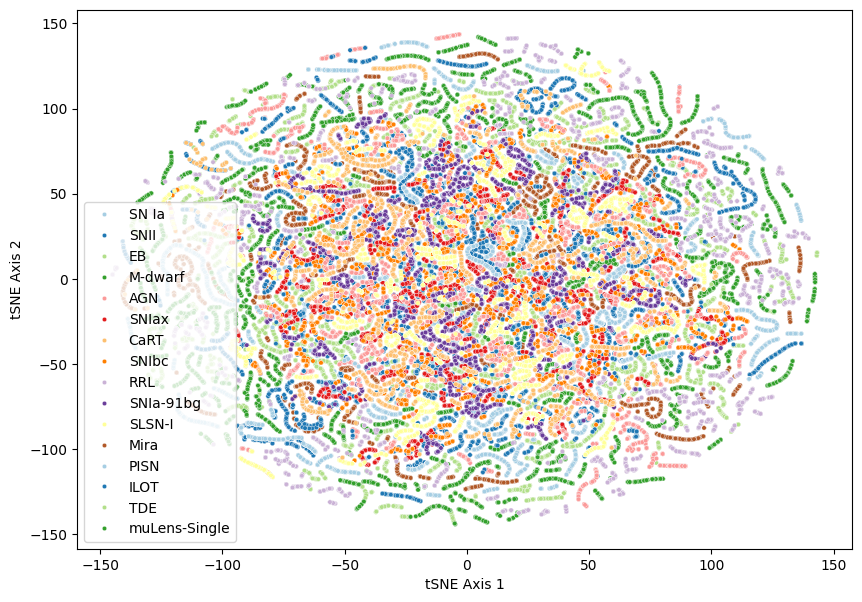

In [151]:
plt.figure(figsize=(10,7))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=np.vectorize(model_nums.get)(y_res), s=10, palette='Paired')
plt.xlabel("tSNE Axis 1");
plt.ylabel("tSNE Axis 2");

There's definitely _some_ structure here, but the classes are not well-separated. Let's try a new dimensionality-reduction method called PaCMAP, which (they claim) does better at preserving both local _and_ global structure of the higher-dimensional data manifold: 

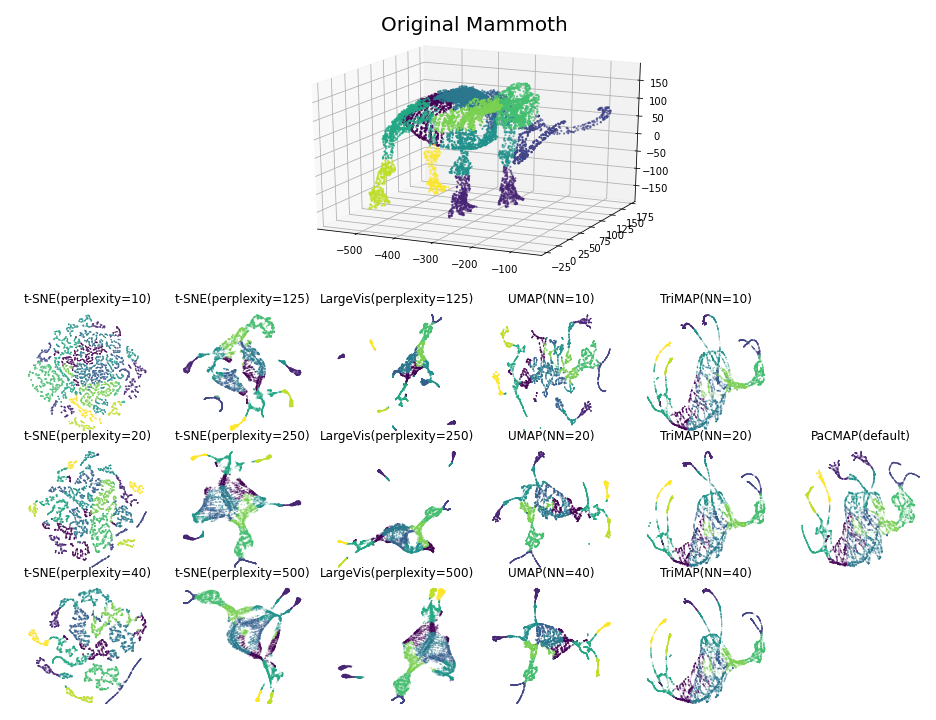

In [152]:
Image(filename='../plots/Mammoth.jpg', width=1024)

They do this by considering pairs of nearby and more distant points. You'll see a similarity between this technique and the triplet loss we'll cover in the next section. You can read more about the package [here](https://github.com/YingfanWang/PaCMAP?tab=readme-ov-file). 

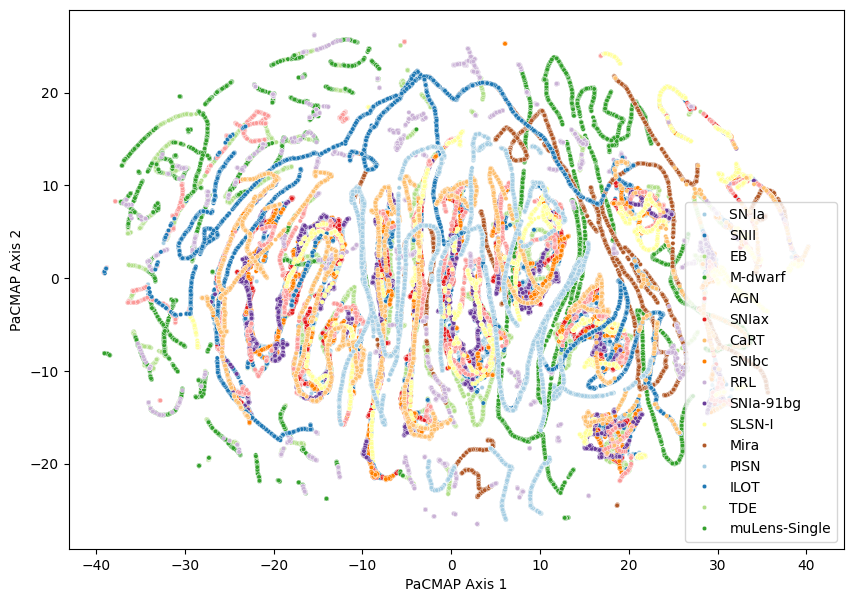

In [158]:
X_embedded = pacmap.PaCMAP().fit_transform(X_res)

plt.figure(figsize=(10,7))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=np.vectorize(model_nums.get)(y_res), s=10, palette='Paired')
plt.xlabel("PaCMAP Axis 1");
plt.ylabel("PaCMAP Axis 2");

This confetti party doesn't _perfectly_ separate classes, but it's a first step. Looking toward the periphery I'd be inclined to say that microlensing events lie in a low-density region. Let's quantify our outliers with the LOF: 

In [51]:
# Next, we define our Local Outlier Factor method for finding anomalies
clf = LocalOutlierFactor(contamination=0.1)
y_pred = clf.fit_predict(mu_list)
outlier_scores = clf.negative_outlier_factor_

In [52]:
getOutliers(y_list, outlier_scores)

Composition of labeled outliers: [('RRL', 62.0), ('EB', 15.0), ('M-dwarf', 13.0), ('SN Ia', 3.0), ('muLens-Single', 2.0), ('SNII', 2.0), ('SNIbc', 2.0), ('Mira', 1.0)]
Composition of labeled inliers: [('SN Ia', 55.00000000000001), ('SNII', 26.0), ('M-dwarf', 6.0), ('RRL', 4.0), ('AGN', 4.0), ('SNIbc', 2.0), ('SLSN-I', 2.0), ('SNIax', 1.0)]


Not bad! Now 55% of our identified outliers are RR-Lyrae variables and 60% of our inliers are SNe Ia. What does hdbscan say?

In [53]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(mu_list)
outlier_scores = clusterer.outlier_scores_

getOutliers(y_list, outlier_scores, asc=True)

Composition of labeled outliers: [('RRL', 55.00000000000001), ('EB', 18.0), ('M-dwarf', 8.0), ('SN Ia', 8.0), ('SNII', 6.0), ('muLens-Single', 2.0), ('Mira', 2.0), ('AGN', 1.0)]
Composition of labeled inliers: [('SN Ia', 52.0), ('SNII', 30.0), ('RRL', 5.0), ('SNIax', 3.0), ('M-dwarf', 3.0), ('AGN', 2.0), ('SNIbc', 2.0), ('TDE', 1.0), ('SNIa-91bg', 1.0), ('EB', 1.0)]


Another method for digging for anomalies is to investigate the _reconstruction error_ - if we do a bad job with a model optimized for performance across the majority of light curves, we might be looking at an out-of-distribution event.

In [54]:
#check the reconstruction errors
reconstruction_list = []
y_list = []
x_list = []
id_list = []

for x, y, ids, lengths in test_loader:
    x = x.to(device)
    x_hat, mu, logvar = model(x, lengths)
    reconstruction = torch.nn.MSELoss(reduction='sum')(x_hat, x)
    reconstruction_list.append(reconstruction.item())
    y_list.append(y)
    id_list.append(ids)
    if len(y_list) > 100:
        break
        
reconstruction_list = np.array(reconstruction_list)
y_list = torch.cat(y_list).cpu().numpy()
id_list = torch.cat(id_list).cpu().numpy()

In [55]:
y_names = np.vectorize(model_nums.get)(y_list)
idx_sorted = np.argsort(-reconstruction_list) #negate the errors so that highest is listed first

#get the 100 light curves with largest reconstruction error
outliers = y_names[idx_sorted][0:100]

c =  Counter(outliers)
c_ranked = [(i, c[i] / len(outliers) * 100.0) for i, count in c.most_common()]
print("Composition of labeled outliers:",c_ranked)

Composition of labeled outliers: [('SN Ia', 50.0), ('SNII', 32.0), ('SNIbc', 5.0), ('RRL', 5.0), ('SNIax', 3.0), ('EB', 3.0), ('SNIa-91bg', 1.0), ('M-dwarf', 1.0)]


This one returned mostly SNe Ia. Let's look at the actual events to figure out why this is the case. Starting with the first one: 

In [350]:
top_anomaly = id_list[idx_sorted[0]]
lcs_test_wMetadata[lcs_test_wMetadata['object_id'] == top_anomaly]

,object_id,mjd,passband,flux,flux_err,detected_bool,ra,decl,ddf_bool,hostgal_specz,...,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
3358956,10934060,59584.0895,0,1706.205322,114.196938,1,98.2617,-15.7139,0,-9.0,...,0.0,0.0,59570.0,40691,2704.0,16815.5,21656.7,22587.8,22473.4,22677.9
3358957,10934060,59588.0754,5,-1178.719849,74.410950,1,98.2617,-15.7139,0,-9.0,...,0.0,0.0,59570.0,40691,2704.0,16815.5,21656.7,22587.8,22473.4,22677.9
3358958,10934060,59589.2521,3,3618.977539,77.766098,1,98.2617,-15.7139,0,-9.0,...,0.0,0.0,59570.0,40691,2704.0,16815.5,21656.7,22587.8,22473.4,22677.9
3358959,10934060,59592.0438,4,-1745.785278,35.446381,1,98.2617,-15.7139,0,-9.0,...,0.0,0.0,59570.0,40691,2704.0,16815.5,21656.7,22587.8,22473.4,22677.9
3358960,10934060,59594.0711,5,2330.751465,75.508781,1,98.2617,-15.7139,0,-9.0,...,0.0,0.0,59570.0,40691,2704.0,16815.5,21656.7,22587.8,22473.4,22677.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3359079,10934060,60659.1851,5,4147.312500,87.403442,1,98.2617,-15.7139,0,-9.0,...,0.0,0.0,59570.0,40691,2704.0,16815.5,21656.7,22587.8,22473.4,22677.9
3359080,10934060,60660.2594,4,3807.181152,68.849251,1,98.2617,-15.7139,0,-9.0,...,0.0,0.0,59570.0,40691,2704.0,16815.5,21656.7,22587.8,22473.4,22677.9
3359081,10934060,60663.2357,3,4735.816406,100.364891,1,98.2617,-15.7139,0,-9.0,...,0.0,0.0,59570.0,40691,2704.0,16815.5,21656.7,22587.8,22473.4,22677.9
3359082,10934060,60666.1569,1,6381.001953,253.351532,1,98.2617,-15.7139,0,-9.0,...,0.0,0.0,59570.0,40691,2704.0,16815.5,21656.7,22587.8,22473.4,22677.9


This one seems very long-lived (detections lasting >500 days!), so it makes sense that it'd be flagged.

Of course, if we identify anomalies by their reconstruction error alone, there's a chance that they are not out-of-distribution for the reasons we want them to be. 

___________

That's all for now, but there are plenty of ways to build on what we've done so far. 

Can we use the classification labels in the training set to find better anomalies? We can investigate this by creating a _conditional VAE_: one conditioned on the labels in our training set. The simplest way to do this is to pass the labels _y_ into our VAE and concatenate them onto our latent vector _z_. Give it a try!

There are many pre-processing steps that we could add to improve our latent representations. For example, we can correct the light curves for Milky Way reddening (parameterized by the `mwebv` variable), remove high-uncertainty observations, or determine some best-fit model with which to interpolate our datapoints. Feel free to play around with these modifications.

One final extension - try downloading the rest of the test data from [https://zenodo.org/records/2539456](https://zenodo.org/records/2539456) and running it through your trained network. Do you find any interesting events in the full dataset that you didn't find in the smaller sample?